# Lab 3
### Using Algorithms and Compute to Identify Clothing Items
Syracuse Applied Data Science, IST-718 Big Data Analytics  

Randall Scott Taylor 
Lab 3, Week 9  
## Objective
The research question is can we use algorithms and compute to identify clothing items?  Specifically, can we determine **which algorithm and compute methodology** provides us the **most efficient** approach for **classifying** simple fashion images?   

 

**Task Lists**

 - [x] Using the base samples available from Zalando   Research: [Fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)
 - [x] Implement at least *two* approaches for classifying the digits 
    * Naïve bayes 
    * Neural Networks 
    * Keras
    * Azure ML  
    * IBM DSX  
    * Boosted trees  
    * Linear classification
#### Answer the following questions:
 - [x] What is the accuracy of each method?
 - [x] What are the trade-offs of each approach?
 - [x] What is the compute performance of each approach? 

In [1]:
#%cd C:/Users/randa/OneDrive/Desktop/homework 3

In [ ]:
!pip install xgboost
!pip install keras
!pip install tensorflow
!pip install django-extensions
!pip install pyparsing
!pip install graphviz
!pip install pydot
!conda install graphviz

### Coding Environment Setup
**Import packages**

In [106]:
# import packages for analysis and modeling
import pandas as pd                            # data frame operations
import numpy as np
import random
import time
import gc
import os
import pickle
from pathlib import Path

import seaborn as sns                          # uses for visualizations
import matplotlib.pyplot as plt                # used for 2D plotting

%matplotlib inline
plt.style.use('fivethirtyeight')


import warnings
from timeit import default_timer               # performance processing time
import logging         

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree   # XGBoost is an optimized distributed gradient boosting library. XGBoost provides a parallel tree boosting (also known as GBDT, GBM)
import xgboost as xgb


In [107]:
# keras Deep Learning packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model

In [108]:
# set global properties
# set global environment properties
dataDir = './data/'
dataMnistDir = './data/fashion/'
outputDir = './output/'
configDir = './config/'
logOutDir = './log/'
imageDir = './images/'
modelDir = './models/'
#modelImprovedDir = './models/improved/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL


In [109]:
#cloning the git hub dist for fashion mnist
!git clone https://github.com/zalandoresearch/fashion-mnist.git


fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [110]:
#pull the randall_util file from github
!git clone https://github.com/randallscott25/utilities


fatal: destination path 'utilities' already exists and is not an empty directory.


In [111]:
import sys
sys.path.insert(0,'utilities')  #/content/fashion-mnist
from randall_utils import * 
import randall_utils as rt

In [112]:
# get loggers
warnings.filterwarnings('ignore')
sh_logger = rt.getSHLogger(name='stream_handler',level=loglevel)

In [113]:
import sys
sys.path.insert(0,'fashion-mnist/utils')  #/content/fashion-mnist
from mnist_reader import*

In [10]:
# custome python packages
#import randall_utils as rt                # custom python helper function
#import evaluate_classifier as evc

In [114]:
import mnist_reader
X, y = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')


In [10]:
features = []
for i in range(1,len(X[0])+1):
    features.append(f'pixel{i}')
features = np.array(features)

In [11]:
# # Each image is 28*28(=784) pixels, hence the 784 features
if sh_logger.info: print(f'MNIST X_train.shape: Row Count [{X.shape[0]}] Column Count: [{X.shape[1]}]')
if sh_logger.info: print(f'MNIST y_train.shape: Row Count [{y.shape[0]}] ')
if sh_logger.info: print(f'MNIST X_trian dtype: [{X.dtype}] y_train dtype: [{y.dtype}]')
if sh_logger.info: print(f'MNIST Testing Set Row Count: [{X_test.shape[0]}] Column Count: [{X_test.shape[1]}]')
if sh_logger.info: print(f'MNIST X_test dtype: [{X_test.dtype}] y_test dtype: [{y_test.dtype}]]')

if sh_logger.info: print(f'Full Training Dataset Info:')
if sh_logger.info: print(f'{np.info(X)}\n')
if sh_logger.info: print(f'Full Testing Dataset Info:')
if sh_logger.info: print(f'{np.info(X_test)}\n')  

MNIST X_train.shape: Row Count [60000] Column Count: [784]
MNIST y_train.shape: Row Count [60000] 
MNIST X_trian dtype: [uint8] y_train dtype: [uint8]
MNIST Testing Set Row Count: [10000] Column Count: [784]
MNIST X_test dtype: [uint8] y_test dtype: [uint8]]
Full Training Dataset Info:
class:  ndarray
shape:  (60000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x1894ffee070
byteorder:  little
byteswap:  False
type: uint8
None

Full Testing Dataset Info:
class:  ndarray
shape:  (10000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x18952cd4070
byteorder:  little
byteswap:  False
type: uint8
None



In [12]:
# split validation data to optimize classifier during training
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)


In [13]:
# number of label classes, 0 - 9
'''Label Description
0--->T-shirt/top
1--->Trouser
2--->Pullover
3--->Dress
4--->Coat
5--->Sandal
6--->Shirt
7--->Sneaker
8--->Bag
9--->Ankle boot'''
num_classes = 10
class_to_label = {0:'TShirt_Top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'AnkleBoot'}
label_to_class = {'TShirt_Top':0, 'Trouser':1, 'Pullover':2, 'Dress':3, 'Coat':4, 'Sandal':5, 'Shirt':6, 'Sneaker':7, 'Bag':8, 'AnkleBoot':9}
num_pixels = X.shape[1]

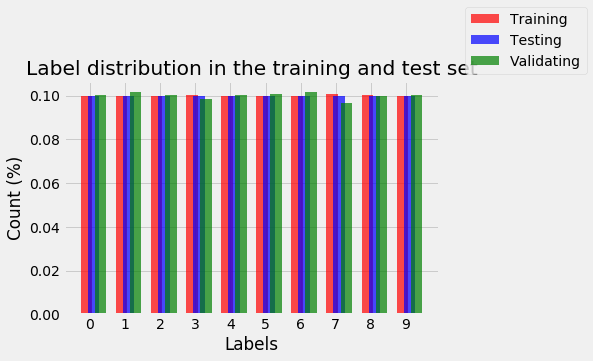

In [14]:
# perform exploratory data analysis techiques
# look at the label balance in training and test sets

# look for imbalance in the sample observations for the class
training_counts = [None] * num_classes
testing_counts = [None] * num_classes
validation_counts = [None] * num_classes

for i in range(num_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)
    validation_counts[i] = len(y_val[y_val==i])/len(y_val)

# plot histogram of the data
train_bar = plt.bar(np.arange(num_classes)-0.1, training_counts, align='center', color = 'r', alpha=0.70, width = 0.33, label='Training')
test_bar = plt.bar(np.arange(num_classes)+0.1, testing_counts, align='center', color = 'b', alpha=0.70, width = 0.33, label = 'Testing')
val_bar = plt.bar(np.arange(num_classes)+0.3, validation_counts, align='center', color = 'g', alpha=0.70, width = 0.33, label = 'Validating')

#plt.figure(figsize=(10.5,7))
plt.xlabel('Labels')
plt.xticks((0,1,2,3,4,5,6,7,8,9))
plt.ylabel('Count (%)')
plt.title('Label distribution in the training and test set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar, val_bar], loc=3)
plt.grid(True)
plt.savefig(f"{imageDir}explore_label_distribution.png", dpi=300)
plt.show()

<Figure size 756x504 with 0 Axes>

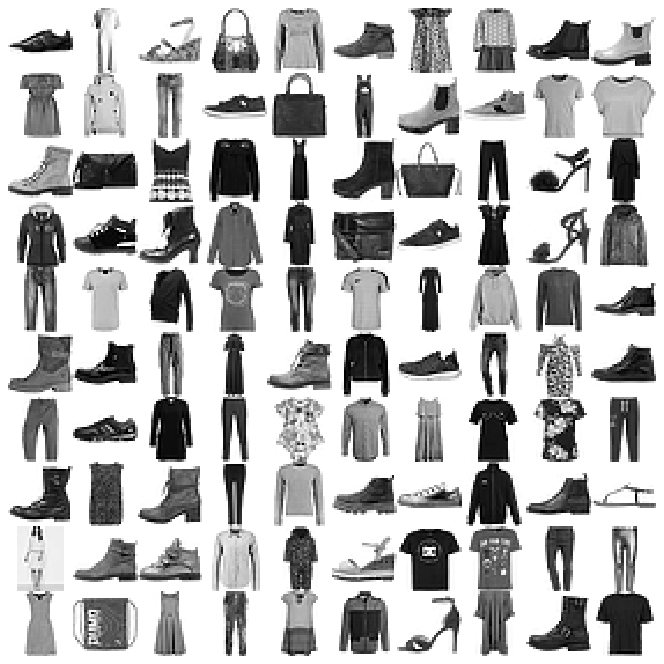

<Figure size 432x288 with 0 Axes>

In [15]:
# plot a sample of the images being trained on
##set up the parameters
plt.figure(figsize=(10.5,7))
example_images = X_train[:100]
rt.plot_sample_images(example_images, images_per_row=10)
plt.savefig(f'{imageDir}explore_sample_images.png', dpi=300)
plt.show()

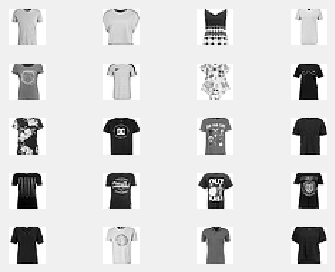

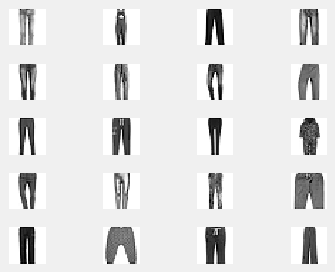

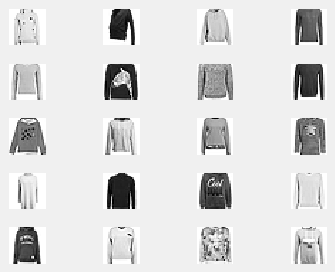

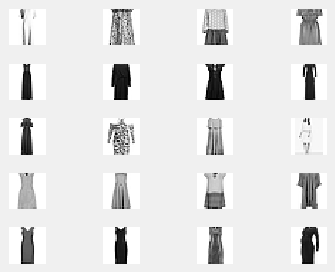

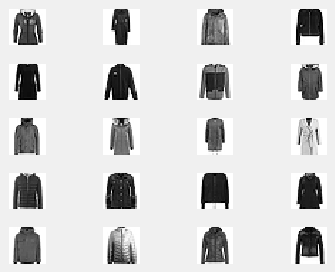

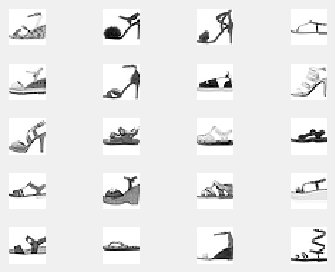

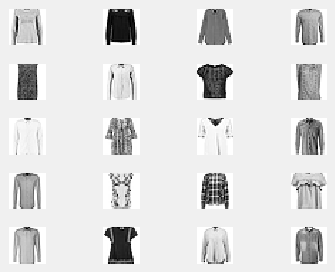

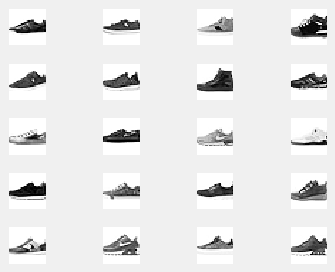

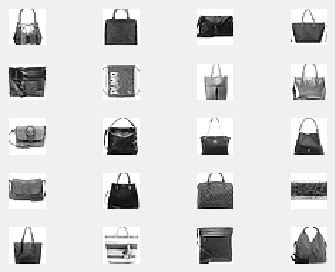

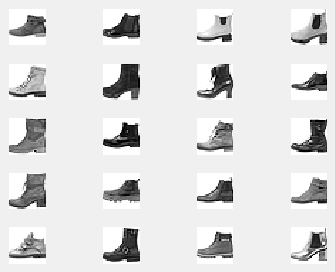

In [16]:
# look at differenct variations of the same image
#plt.figure(figsize=(10, 7.5))
imageName = 'class_images.png'
#imageType = 6
for i in range(num_classes):
    saveImage = f'{i}_{imageName}'
    rt.visualize_image_variations(X_train, y_train, i, 20, (28,28))

In [17]:
# normalize the data set to 0-to-1 range
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
# normalize inputs from RGB color to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

# save off for CNN
y_train_nn = y_train.copy()
y_val_nn = y_val.copy()
y_test_nn = y_test.copy()

# one hot encoding
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train).astype('int32')
y_val = lbe.fit_transform(y_val).astype('int32')


# input shape
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [18]:
# modeling programming variables
# perform model creation and validation techniques
modelsPerformance = {'ModelName':[], 
                     'TestAccuracyScore':[],
                     'PredictAccuracyScore':[] ,
                     'TrainTime':[], 
                     'TestTime':[],
                     'ScoreTime':[], 
                     'PredictTime':[]
                     }
# labels used for plotting
labels = [l for l in class_to_label.keys()]

## 2.0 MODEL - RandomForestClassifier
-----------------------------------------------------------------------------
Python Package: scikit-learn v0.21.3 [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).  
### 2.1 Create Models - RandomForestClassifier
 
#### Random Forest Attributes
See scikit learn [glossary](https://scikit-learn.org/stable/glossary.html#term-warm-start) for indepth details.
#### 2.1 Model Build

In [19]:
# instantiate base class - accepting default attributes
rf_base = RandomForestClassifier(n_estimators=100,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=None,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=None,                  # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=None,            # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=2,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )

#### 2.2 Model Train / Validate / Score

Starting Model Training at time: 09:01:41.161396
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


Training Complete - Execution Time: [67.0335416]
Starting Model Prediction at time: 09:02:48.428461


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Predicting on Validation dataset Complete - Execution Time: [0.5270518000000095]
Starting Model Accuracy Scoring at time: 09:02:48.956455
Scoring Complete - Execution Time: [0.0]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.83      1202
      Class1       1.00      0.97      0.98      1219
      Class2       0.79      0.82      0.80      1205
      Class3       0.87      0.92      0.89      1184
      Class4       0.77      0.84      0.80      1202
      Class5       0.97      0.96      0.97      1211
      Class6       0.74      0.59      0.66      1218
      Class7       0.94      0.94      0.94      1159
      Class8       0.96      0.97      0.96      1197
      Class9       0.95      0.96      0.95      1203

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000


Confusion Matrix Report:
[[1024    0   26   51    3    1   9

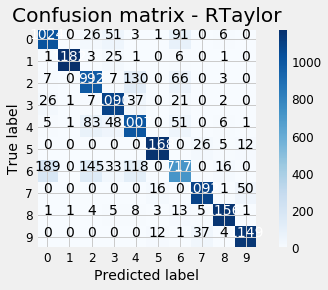

In [20]:
# Construct Baseline
#saveImgAs = 'test'
rf = rt.train_validate_classifier(rf_base, 'rf_base', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)
# confusion matrix evaluation
#cm = confusion_matrix(base_test_pred_table.iloc[:,0],base_test_pred_table.iloc[:,1], labels=[0,1,2,3,4,5,6,7,8,9])
#rt.plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], f'{imageDir}nn_base_confusion_matrix.png')

In [21]:
# reading model in from file
import pickle

with open(f'{modelDir}rf_base','rb') as f:
    rf = pickle.load(f)
    
with open(f'{modelDir}rf_base_fit','rb') as f:
    rf_base_fit = pickle.load(f)

In [22]:
rf_base_fit.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': False}

In [23]:
rf_pred = rt.predict_classifier(rf, 'rf_base', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)
#rf_pred

Starting Model Prediction at time: 09:05:20.505559



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Complete Model Prediction - Execution Time: [0.4491014999999834]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1287, 2)
Miss Classified Percent: 0.1287
Total Number of points: [10000]  Mislabeled Points: [1287]
Percent Accurately Labeled: [0.8713]
Accuracy Score: [0.8713]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.84      1000
      Class1       0.99      0.96      0.98      1000
      Class2       0.75      0.80      0.77      1000
      Class3       0.86      0.90      0.88      1000
      Class4       0.76      0.80      0.78      1000
      Class5       0.97      0.95      0.96      1000
      Class6       0.71      0.58      0.64      1000
      Class7       0.92      0.95      0.94      1000
      Class8       0.95      0.97      0.96      1000
      Class9       0.95      0.94 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [24]:
with open(f'{modelDir}rf_base_predictions','rb') as f:
    rf_pred = pickle.load(f)

      feature  importance
574  pixel575    0.009759
518  pixel519    0.007549
462  pixel463    0.007378
686  pixel687    0.007083
602  pixel603    0.006819
490  pixel491    0.006014
630  pixel631    0.005886
546  pixel547    0.005882
263  pixel264    0.005747
173  pixel174    0.005628


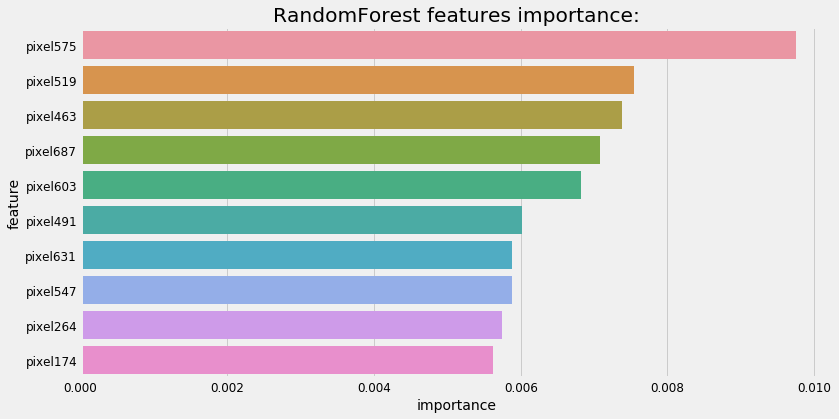

In [25]:
# Random Forest - Feature importance
rt.feature_importances(features, rf, 'RandomForest', sh_logger)

In [26]:
# returns best predictor from the cross fold training process
rf_base_cv = rt.trainWithCrossValidate(rf, 'rf_base_cv', X_train, y_train, modelsPerformance, sh_logger, modelDir)

Starting Model Cross Validate Training at time: 09:11:58.913622

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   52.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


Cross Validate Complete - Execution Time: [264.3835421]

Scorer Names: ['estimator', 'fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'train_precision_macro', 'train_recall_macro']
Fit Time:               [52.26706743 50.48107195 50.61107278 50.34305644 50.54505324]
Score Time:             [0.41098499 0.42000008 0.41198444 0.42401695 0.4180162 ]
Test Recall Scores:     [0.88292147 0.87775917 0.87859953 0.87714396 0.87781325]
Test Precision Scores:  [0.88228597 0.87649844 0.87749313 0.87625559 0.87693347]
Train Recall Scores:    [1.         0.99997418 1.         1.         1.        ]
Train Precision Scores: [1.         0.99997394 1.         1.         1.        ]


In [27]:
# reading model in from file
import pickle

with open(f'{modelDir}rf_base_cv_cv','rb') as f:
    rf_base_cv = pickle.load(f)

In [28]:
# use best CV to predict unseen dataset
rf_base_cv_pred = rt.predict_classifier(rf_base_cv, 'rf_base_cv', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 09:19:50.836796



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Complete Model Prediction - Execution Time: [0.4664580000001024]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1287, 2)
Miss Classified Percent: 0.1287
Total Number of points: [10000]  Mislabeled Points: [1287]
Percent Accurately Labeled: [0.8713]
Accuracy Score: [0.8713]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.84      1000
      Class1       0.99      0.96      0.98      1000
      Class2       0.75      0.80      0.77      1000
      Class3       0.86      0.90      0.88      1000
      Class4       0.76      0.80      0.78      1000
      Class5       0.97      0.95      0.96      1000
      Class6       0.71      0.58      0.64      1000
      Class7       0.92      0.95      0.94      1000
      Class8       0.95      0.97      0.96      1000
      Class9       0.95      0.94 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [29]:
import pickle

with open(f'{modelDir}rf_base_cv_predictions','rb') as f:
    rf_base_cv_pred = pickle.load(f)

In [ ]:
# plot out sample images from the classes that scored lower than 90%

In [30]:
rfTuneTrialIndex = 0

In [31]:
# instantiate base class - accepting default attributes
rf_ = RandomForestClassifier(n_estimators=200,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=10,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=5,                     # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=42,              # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=0,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )

Starting Model Training at time: 09:20:31.939489
Training Complete - Execution Time: [23.48046279999994]
Starting Model Prediction at time: 09:20:55.512513
Predicting on Validation dataset Complete - Execution Time: [0.37057919999983824]
Starting Model Accuracy Scoring at time: 09:20:55.884532
Scoring Complete - Execution Time: [0.0]

              precision    recall  f1-score   support

      Class0       0.79      0.84      0.82      1202
      Class1       1.00      0.95      0.98      1219
      Class2       0.74      0.75      0.74      1205
      Class3       0.81      0.91      0.86      1184
      Class4       0.69      0.82      0.75      1202
      Class5       0.97      0.92      0.95      1211
      Class6       0.75      0.50      0.60      1218
      Class7       0.89      0.92      0.91      1159
      Class8       0.96      0.96      0.96      1197
      Class9       0.92      0.94      0.93      1203

    accuracy                           0.85     12000
   macro avg 

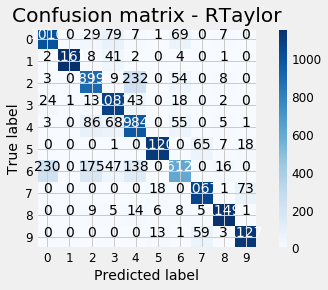

In [32]:
# run validation on tunning parameters
rfTuneTrialIndex = rfTuneTrialIndex + 1
rf = rt.train_validate_classifier(rf_, f'rf_tun_{rfTuneTrialIndex}', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)


In [33]:
# reading model in from file
import pickle
#rfTuneTrialIndex = rfTuneTrialIndex + 1 # only use this line after training, and kernel restarted
with open(f'{modelDir}rf_tun_{rfTuneTrialIndex}','rb') as f:
    rf = pickle.load(f)
    
with open(f'{modelDir}rf_tun_{rfTuneTrialIndex}_fit','rb') as f:
    rf_tun_fit = pickle.load(f)

In [34]:
rf_tun_fit.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 5,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
rf_pred = rt.predict_classifier(rf, f'rf_tun_{rfTuneTrialIndex}', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 09:23:56.356981

Complete Model Prediction - Execution Time: [0.35537030000000414]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1565, 2)
Miss Classified Percent: 0.1565
Total Number of points: [10000]  Mislabeled Points: [1565]
Percent Accurately Labeled: [0.8435]
Accuracy Score: [0.8435]

              precision    recall  f1-score   support

      Class0       0.80      0.83      0.81      1000
      Class1       0.99      0.94      0.96      1000
      Class2       0.71      0.73      0.72      1000
      Class3       0.82      0.90      0.86      1000
      Class4       0.68      0.80      0.74      1000
      Class5       0.98      0.93      0.95      1000
      Class6       0.70      0.49      0.58      1000
      Class7       0.89      0.92      0.91      1000
      Class8       0.95      0.96  

## 3.0 Model - Boosted Tree
### XGBoost
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting.   

See documentation for more indepth details.
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/)    
* [XGBoost Parameter details](https://xgboost.readthedocs.io/en/latest/parameter.html)  
* [XGBClassifier Example](https://www.programcreek.com/python/example/99824/xgboost.XGBClassifier)   


In [36]:
# initialize a base-line xgboost object
xgbc_base = XGBClassifier(
                        n_estimators=50, 
                        max_depth=5
                        )

# 3.1 Model training, validation, and scoring

Starting Model Training at time: 09:24:04.604873
Training Complete - Execution Time: [169.8755271]
Starting Model Prediction at time: 09:26:54.488358
Predicting on Validation dataset Complete - Execution Time: [0.3386874999998781]
Starting Model Accuracy Scoring at time: 09:26:54.828354
Scoring Complete - Execution Time: [0.0]

              precision    recall  f1-score   support

      Class0       0.83      0.86      0.85      1202
      Class1       1.00      0.97      0.99      1219
      Class2       0.82      0.84      0.83      1205
      Class3       0.88      0.92      0.90      1184
      Class4       0.81      0.84      0.82      1202
      Class5       0.98      0.97      0.97      1211
      Class6       0.74      0.66      0.70      1218
      Class7       0.95      0.96      0.95      1159
      Class8       0.97      0.96      0.97      1197
      Class9       0.96      0.96      0.96      1203

    accuracy                           0.89     12000
   macro avg       0

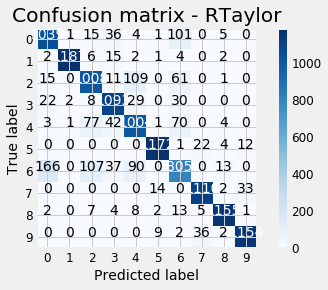

In [37]:
# Construct Baseline
modelsPerformance['ModelName'].append('xgbc_base')
xgbc_base = rt.train_validate_classifier(xgbc_base, 'xgbc_base', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels, f'{imageDir}nn_base_confusion_matrix.png')


In [38]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbc_base','rb') as f:
    xgbc_base = pickle.load(f)
    
with open(f'{modelDir}xgbc_base_fit','rb') as f:
    xgbc_base_fit = pickle.load(f)

In [39]:
xgbc_base_fit.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [40]:
xgbc_pred = rt.predict_classifier(xgbc_base, 'xgbc_base', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 09:47:20.672405

Complete Model Prediction - Execution Time: [0.28434399999969173]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1200, 2)
Miss Classified Percent: 0.12
Total Number of points: [10000]  Mislabeled Points: [1200]
Percent Accurately Labeled: [0.88]
Accuracy Score: [0.88]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.83      1000
      Class1       0.99      0.97      0.98      1000
      Class2       0.78      0.80      0.79      1000
      Class3       0.88      0.90      0.89      1000
      Class4       0.79      0.81      0.80      1000
      Class5       0.98      0.97      0.97      1000
      Class6       0.69      0.62      0.65      1000
      Class7       0.94      0.96      0.95      1000
      Class8       0.97      0.97      0.

In [41]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbc_base_predictions','rb') as f:
    xgbc_pred = pickle.load(f)

      feature  importance
346  pixel347    0.038836
337  pixel338    0.035807
627  pixel628    0.029992
499  pixel500    0.028552
89    pixel90    0.028080
779  pixel780    0.026481
490  pixel491    0.024472
247  pixel248    0.022719
655  pixel656    0.020449
471  pixel472    0.018193


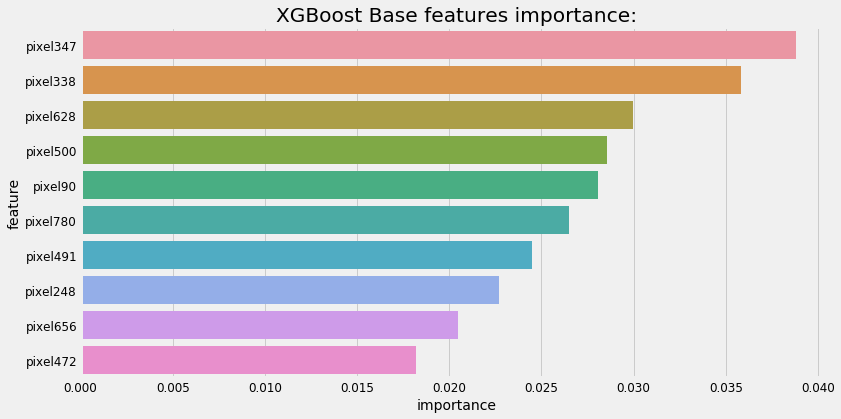

In [42]:
# XGBoost - Feature importance
rt.feature_importances(features, xgbc_base, 'XGBoost Base', sh_logger)

#### 3.3 Model - Tune

In [43]:
#XGBoost with GridSearch
gridParameters = [{
    'max_depth':[5,10],
    'n_estimators':[100],
    'learning_rate':[0.05, 0.1],
    'colsample_bytree':[0.8, 0.95]
}]

# instantiate classifier object
xgbs_gs = XGBClassifier(random_state=42)

Starting Model GridSearch Training at time: 07:41:40.027096
Training Complete - Execution Time: [18101.8672128]
Starting Model GridSearch Prediction at time: 12:43:21.930764
Predicting on Validation dataset Complete - Execution Time: [0.633935100002418]
Starting Model Accuracy Scoring at time: 12:43:22.566550
Scoring Complete - Execution Time: [0.0]

              precision    recall  f1-score   support

      Class0       0.83      0.88      0.86      1202
      Class1       1.00      0.98      0.99      1219
      Class2       0.82      0.84      0.83      1205
      Class3       0.88      0.93      0.90      1184
      Class4       0.81      0.85      0.83      1202
      Class5       0.98      0.97      0.97      1211
      Class6       0.77      0.65      0.70      1218
      Class7       0.95      0.96      0.95      1159
      Class8       0.97      0.97      0.97      1197
      Class9       0.96      0.96      0.96      1203

    accuracy                           0.90     120

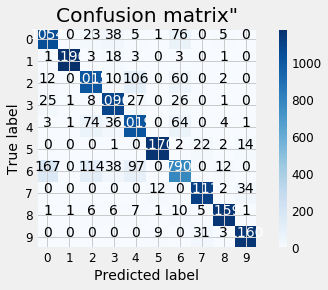

In [45]:
# execute grid search on XGBoost object - performs training, testing on validation data and scoring
xgbc_gs = rt.grid_search(xgbs_gs, 'xgbs_gs', gridParameters, X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)

In [182]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbs_gs','rb') as f:
    xgbc_gs = pickle.load(f)

In [184]:
xgbc_gs.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [178]:
# run prediction on the unseen test dataset
xgbc_gs_pred = rt.predict_classifier(xgbc_gs, 'xgbc_gs', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 15:32:33.781782

Complete Model Prediction - Execution Time: [0.5474671999982093]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           2
Miss Classified DF Shape: (2493, 2)
Miss Classified Percent: 0.2493
Total Number of points: [10000]  Mislabeled Points: [2493]
Percent Accurately Labeled: [0.7507]
Accuracy Score: [0.7507]

              precision    recall  f1-score   support

      Class0       0.82      0.56      0.66      1000
      Class1       0.89      0.91      0.90      1000
      Class2       0.50      0.86      0.63      1000
      Class3       0.85      0.80      0.82      1000
      Class4       0.55      0.60      0.58      1000
      Class5       0.99      0.82      0.90      1000
      Class6       0.50      0.28      0.36      1000
      Class7       0.96      0.80      0.87      1000
      Class8       0.76      0.93   

In [185]:
xgbc_gs

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [181]:
xgbc_gs_pred

array([9, 2, 1, ..., 8, 1, 8])

In [186]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbs_gs_predictions','rb') as f:
    xgbc_gs_pred = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './models/xgbs_gs_predictions'

#### 3.4 Model - Evaluate Tuned Parameters

      feature  importance
346  pixel347    0.042538
655  pixel656    0.041263
490  pixel491    0.035658
337  pixel338    0.035086
471  pixel472    0.034461
117  pixel118    0.020779
339  pixel340    0.020627
733  pixel734    0.017516
178  pixel179    0.016120
338  pixel339    0.016114


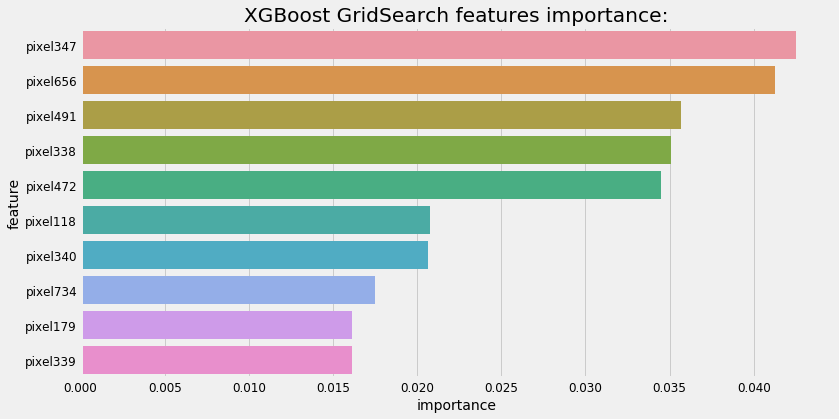

In [47]:
# XGBoost - Feature importance
rt.feature_importances(features, xgbc_gs, 'XGBoost GridSearch', sh_logger)

In [122]:
# fix TestTime - CV function didn't update - set to zero
modelsPerformance['TestTime'] = [0.6415216000000044,0.0,0.43304430000000593,0.6098084000000199,1.900499299998046]
#mp = pd.DataFrame(modelsPerformance)
mp = pd.DataFrame.from_dict(modelsPerformance, orient='index')
mp.to_csv(f'{dataDir}models_performance.csv', index=False)
mp

,0,1,2,3,4,5,6
ModelName,rf_base,rf_base_cv,rf_tun_1,xgbc_base,xgbc_base,NaN,NaN
TestAccuracyScore,0.881417,0.882286,0.851,0.893917,0.8935,0.92900,NaN
PredictAccuracyScore,0.8974,0.9314,0.7507,None,None,NaN,NaN
TrainTime,67.0335,52.2671,23.4805,169.876,None,NaN,NaN
TestTime,0.641522,0,0.433044,0.609808,1.9005,NaN,NaN
ScoreTime,0,0.410985,0,0,0.730625,2.70379,NaN
PredictTime,0.449101,0.466458,0.35537,0.284344,0.577422,0.00000,0.539286


In [120]:
modelsPerformance

{'ModelName': ['rf_base', 'rf_base_cv', 'rf_tun_1', 'xgbc_base', 'xgbc_base'],
 'TestAccuracyScore': [0.8814166666666666,
  0.882285972718668,
  0.851,
  0.8939166666666667,
  0.8934999704360962,
  0.9290000200271606],
 'PredictAccuracyScore': [0.8974, 0.9314, 0.7507],
 'TrainTime': [67.0335416, 52.267067432403564, 23.48046279999994, 169.8755271],
 'TestTime': [0.0, 0.0],
 'ScoreTime': [0.0,
  0.41098499298095703,
  0.0,
  0.0,
  0.7306247000005897,
  2.7037901999992755],
 'PredictTime': [0.4491014999999834,
  0.4664580000001024,
  0.35537030000000414,
  0.28434399999969173,
  0.5774216999998316,
  0.0,
  0.5392861000000266]}

## 4.0 Model - CNN with Keras
Python package: [keras](https://keras.io/)   
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.  

* Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).  
* Supports both convolutional networks and recurrent networks, as well as combinations of the two.  
* Runs seamlessly on CPU and GPU.  

In [124]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.3.0


In [125]:
#pulling in the same data as before but from a different source--not really necessary

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 1s 0us/step


In [126]:
class_to_label

{0: 'TShirt_Top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'AnkleBoot'}

In [127]:
#again confirming my table sizes=looks right (28x28 is pixel size of each image)
print(train_images.shape)
print(len(train_labels))

(60000, 28, 28)
60000


In [128]:
print(test_images.shape)
print(len(test_labels))

(10000, 28, 28)
10000


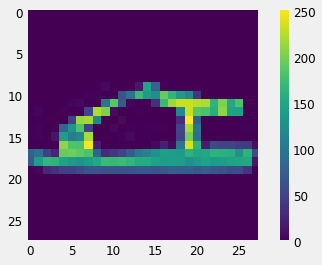

In [129]:
#demonstrating what the pics look like in terms of pixel darkness--these will be changed to B&W for actual processing
plt.figure()
plt.imshow(train_images[120])
plt.colorbar()
plt.grid(False)
plt.show()

In [130]:
train_images = train_images / 255.0

test_images = test_images / 255.0

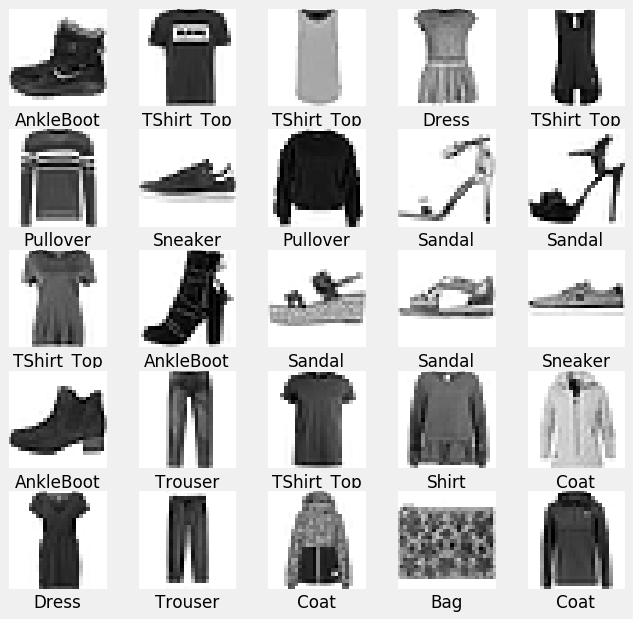

In [132]:
#looking at an assortment of different varities of clothing included in the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_to_label[train_labels[i]])
plt.show()

In [133]:
%%time 
#building my model

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Wall time: 23 ms


In [134]:
%%time 
#compliling the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Wall time: 7 ms


In [135]:
%%time 
#initial run w/ ten epochs
history  = model.fit(train_images, train_labels, validation_data=(test_images,test_labels), epochs=10, batch_size=1000, verbose=2)


Epoch 1/10
60/60 - 0s - loss: 0.8316 - accuracy: 0.7313 - val_loss: 0.5696 - val_accuracy: 0.8116
Epoch 2/10
60/60 - 0s - loss: 0.5065 - accuracy: 0.8269 - val_loss: 0.4976 - val_accuracy: 0.8295
Epoch 3/10
60/60 - 0s - loss: 0.4494 - accuracy: 0.8450 - val_loss: 0.4664 - val_accuracy: 0.8375
Epoch 4/10
60/60 - 0s - loss: 0.4203 - accuracy: 0.8541 - val_loss: 0.4452 - val_accuracy: 0.8450
Epoch 5/10
60/60 - 0s - loss: 0.4023 - accuracy: 0.8598 - val_loss: 0.4413 - val_accuracy: 0.8432
Epoch 6/10
60/60 - 0s - loss: 0.3866 - accuracy: 0.8649 - val_loss: 0.4296 - val_accuracy: 0.8484
Epoch 7/10
60/60 - 0s - loss: 0.3678 - accuracy: 0.8714 - val_loss: 0.4036 - val_accuracy: 0.8578
Epoch 8/10
60/60 - 0s - loss: 0.3585 - accuracy: 0.8737 - val_loss: 0.3969 - val_accuracy: 0.8571
Epoch 9/10
60/60 - 0s - loss: 0.3454 - accuracy: 0.8780 - val_loss: 0.3882 - val_accuracy: 0.8624
Epoch 10/10
60/60 - 0s - loss: 0.3355 - accuracy: 0.8816 - val_loss: 0.3823 - val_accuracy: 0.8622
Wall time: 4.21 s


In [136]:
history

In [137]:
%%time 
#second run with 300 epochs
history  = model.fit(train_images, train_labels, validation_data=(test_images,test_labels), epochs=300, batch_size=1000, verbose=2)


Epoch 1/300
60/60 - 0s - loss: 0.3301 - accuracy: 0.8837 - val_loss: 0.3788 - val_accuracy: 0.8632
Epoch 2/300
60/60 - 0s - loss: 0.3196 - accuracy: 0.8868 - val_loss: 0.3717 - val_accuracy: 0.8680
Epoch 3/300
60/60 - 0s - loss: 0.3123 - accuracy: 0.8897 - val_loss: 0.3688 - val_accuracy: 0.8664
Epoch 4/300
60/60 - 0s - loss: 0.3110 - accuracy: 0.8891 - val_loss: 0.3654 - val_accuracy: 0.8686
Epoch 5/300
60/60 - 0s - loss: 0.3007 - accuracy: 0.8939 - val_loss: 0.3601 - val_accuracy: 0.8704
Epoch 6/300
60/60 - 0s - loss: 0.2968 - accuracy: 0.8936 - val_loss: 0.3547 - val_accuracy: 0.8722
Epoch 7/300
60/60 - 0s - loss: 0.2905 - accuracy: 0.8966 - val_loss: 0.3551 - val_accuracy: 0.8715
Epoch 8/300
60/60 - 0s - loss: 0.2830 - accuracy: 0.8990 - val_loss: 0.3469 - val_accuracy: 0.8761
Epoch 9/300
60/60 - 0s - loss: 0.2776 - accuracy: 0.9015 - val_loss: 0.3523 - val_accuracy: 0.8734
Epoch 10/300
60/60 - 0s - loss: 0.2733 - accuracy: 0.9035 - val_loss: 0.3453 - val_accuracy: 0.8757
Epoch 11/

60/60 - 0s - loss: 0.1293 - accuracy: 0.9563 - val_loss: 0.3543 - val_accuracy: 0.8870
Epoch 84/300
60/60 - 0s - loss: 0.1264 - accuracy: 0.9573 - val_loss: 0.3595 - val_accuracy: 0.8872
Epoch 85/300
60/60 - 0s - loss: 0.1287 - accuracy: 0.9560 - val_loss: 0.3542 - val_accuracy: 0.8894
Epoch 86/300
60/60 - 0s - loss: 0.1261 - accuracy: 0.9570 - val_loss: 0.3614 - val_accuracy: 0.8873
Epoch 87/300
60/60 - 0s - loss: 0.1237 - accuracy: 0.9575 - val_loss: 0.3589 - val_accuracy: 0.8848
Epoch 88/300
60/60 - 0s - loss: 0.1235 - accuracy: 0.9587 - val_loss: 0.3551 - val_accuracy: 0.8887
Epoch 89/300
60/60 - 0s - loss: 0.1222 - accuracy: 0.9592 - val_loss: 0.3604 - val_accuracy: 0.8864
Epoch 90/300
60/60 - 0s - loss: 0.1205 - accuracy: 0.9595 - val_loss: 0.3609 - val_accuracy: 0.8879
Epoch 91/300
60/60 - 0s - loss: 0.1192 - accuracy: 0.9599 - val_loss: 0.3651 - val_accuracy: 0.8872
Epoch 92/300
60/60 - 0s - loss: 0.1187 - accuracy: 0.9597 - val_loss: 0.3663 - val_accuracy: 0.8863
Epoch 93/300


Epoch 165/300
60/60 - 0s - loss: 0.0644 - accuracy: 0.9804 - val_loss: 0.4645 - val_accuracy: 0.8834
Epoch 166/300
60/60 - 0s - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.4642 - val_accuracy: 0.8842
Epoch 167/300
60/60 - 0s - loss: 0.0635 - accuracy: 0.9808 - val_loss: 0.4691 - val_accuracy: 0.8812
Epoch 168/300
60/60 - 0s - loss: 0.0641 - accuracy: 0.9804 - val_loss: 0.4707 - val_accuracy: 0.8832
Epoch 169/300
60/60 - 0s - loss: 0.0628 - accuracy: 0.9814 - val_loss: 0.4755 - val_accuracy: 0.8819
Epoch 170/300
60/60 - 0s - loss: 0.0620 - accuracy: 0.9810 - val_loss: 0.4837 - val_accuracy: 0.8826
Epoch 171/300
60/60 - 0s - loss: 0.0624 - accuracy: 0.9811 - val_loss: 0.4745 - val_accuracy: 0.8825
Epoch 172/300
60/60 - 0s - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.5074 - val_accuracy: 0.8806
Epoch 173/300
60/60 - 0s - loss: 0.0684 - accuracy: 0.9786 - val_loss: 0.4823 - val_accuracy: 0.8826
Epoch 174/300
60/60 - 0s - loss: 0.0654 - accuracy: 0.9798 - val_loss: 0.4762 - val_accurac

60/60 - 0s - loss: 0.0328 - accuracy: 0.9913 - val_loss: 0.5981 - val_accuracy: 0.8792
Epoch 247/300
60/60 - 0s - loss: 0.0320 - accuracy: 0.9916 - val_loss: 0.6098 - val_accuracy: 0.8820
Epoch 248/300
60/60 - 0s - loss: 0.0331 - accuracy: 0.9906 - val_loss: 0.6151 - val_accuracy: 0.8821
Epoch 249/300
60/60 - 0s - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.6182 - val_accuracy: 0.8804
Epoch 250/300
60/60 - 0s - loss: 0.0330 - accuracy: 0.9912 - val_loss: 0.6079 - val_accuracy: 0.8805
Epoch 251/300
60/60 - 0s - loss: 0.0335 - accuracy: 0.9906 - val_loss: 0.6052 - val_accuracy: 0.8805
Epoch 252/300
60/60 - 0s - loss: 0.0305 - accuracy: 0.9920 - val_loss: 0.6324 - val_accuracy: 0.8805
Epoch 253/300
60/60 - 0s - loss: 0.0306 - accuracy: 0.9920 - val_loss: 0.6113 - val_accuracy: 0.8802
Epoch 254/300
60/60 - 0s - loss: 0.0289 - accuracy: 0.9932 - val_loss: 0.6160 - val_accuracy: 0.8812
Epoch 255/300
60/60 - 0s - loss: 0.0324 - accuracy: 0.9907 - val_loss: 0.6104 - val_accuracy: 0.8812
Epoc

In [138]:
#evaluating test accuracy of final epcoh. Obviously the model was overfitting the test dat (99% accuracy there to 88% here)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)
#Test accuracy: 0.8872 --suggests overfitting of training model :/

313/313 [==============================] - 0s 1ms/step - loss: 0.7168 - accuracy: 0.8767
Test accuracy: 0.8766999840736389


In [139]:
#generating my predictions
predictions = model.predict(test_images)

In [140]:
#looking at a prediction for the first image-- it is going through and ranking the likilhood that it is 0-9, whichever is highest is choosen as the actual prediction
predictions[0]

array([2.7520467e-21, 2.0074221e-19, 1.7824684e-22, 2.8415152e-31,
       3.1265685e-19, 1.0020128e-10, 2.5914174e-16, 1.9775752e-07,
       1.2833886e-11, 9.9999976e-01], dtype=float32)

In [141]:
np.argmax(predictions[0])


9

In [149]:
#comparing our prediction to the actual value
test_labels[0]


9

In [157]:
#creating a graph to show the predictions for  images

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_to_label[predicted_label],
                                100*np.max(predictions_array),
                                class_to_label[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

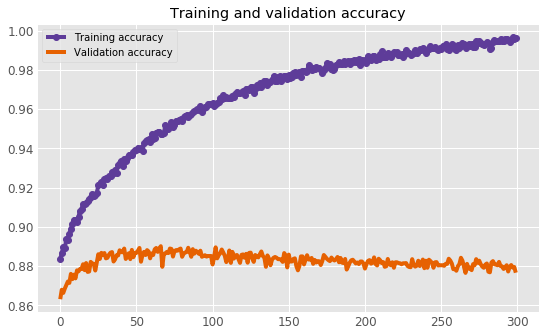

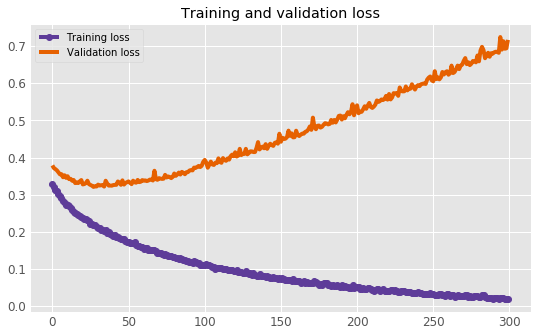

In [158]:
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)

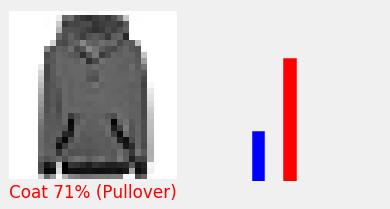

In [159]:
#sometimes even if we're sure it's one--it isn't....
i = 9441
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

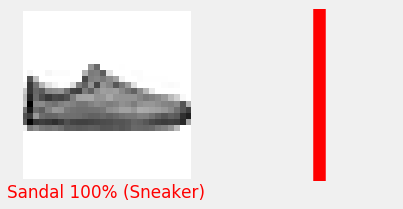

In [160]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

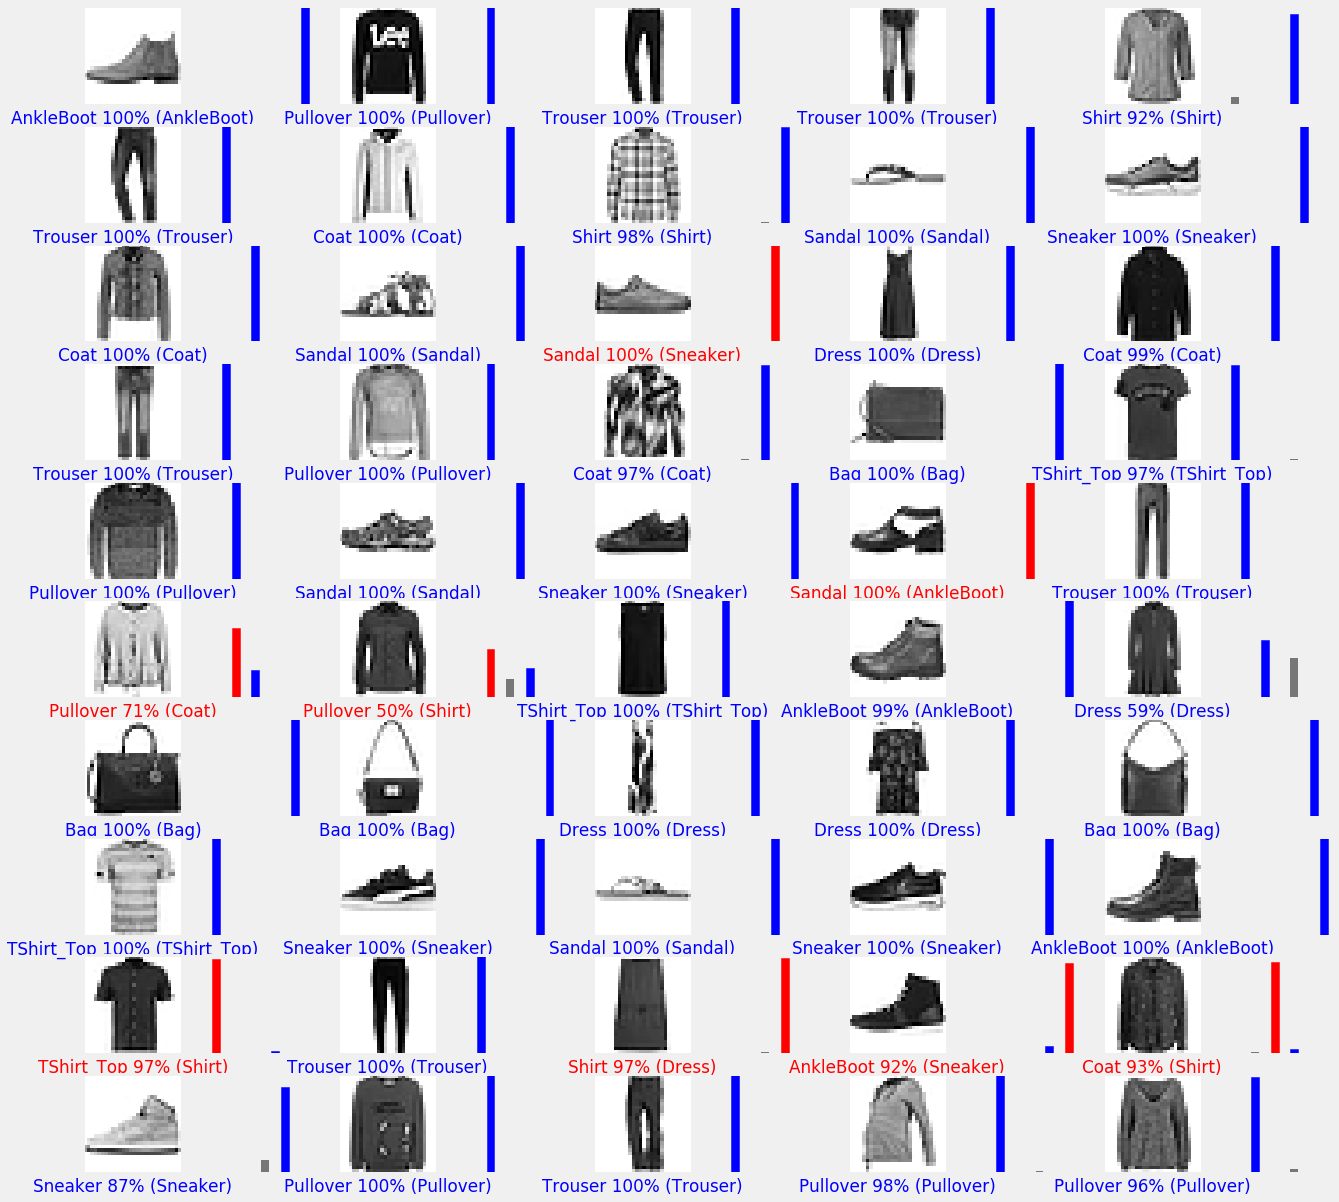

In [161]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red, gray= unsure
num_rows = 10
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [162]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape) 

(28, 28)


In [163]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [164]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.7520467e-21 2.0074221e-19 1.7824548e-22 2.8414936e-31 3.1265445e-19
  1.0020147e-10 2.5914073e-16 1.9775619e-07 1.2833911e-11 9.9999976e-01]]


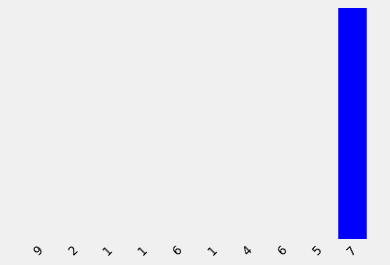

In [167]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), test_labels, rotation=45)

In [168]:
predictions = model.predict(test_images)
predictions[0]
np.argmax(predictions[0])
test_labels[0]


9

In [169]:
#creating a loop to make a confusion matrix-- only selecting the "best guess" for the prediction value
Image=[]
Pred=[]
TrueLabel=[]
Images=np.array([np.arange(10000)]*1).T
for i in Images:
    Image.append(i)
    predictions[i]
    Pred.append(np.argmax(predictions[i]))
    TrueLabel.append(test_labels[i])

In [170]:
len(Pred)
len(Images)
len(TrueLabel)

10000

In [171]:
d = {'Image':Image, "Prediction":Pred, "TrueLabel":TrueLabel}

In [172]:
df=pd.DataFrame(d)

In [173]:
df.head()

,Image,Prediction,TrueLabel
0,[0],9,[9]
1,[1],2,[2]
2,[2],1,[1]
3,[3],1,[1]
4,[4],6,[6]


In [174]:
#exporting dataframe to excel to make confusion matrix!
df.to_csv('finalPred.csv')